In [1]:
#!pip install transformers

#!pip install torch

In [2]:
from transformers import BertModel, BertTokenizerFast, BertForMaskedLM, BertForPreTraining

import torch

import pandas as pd

2025-05-26 16:08:55.247525: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748275735.581178      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748275735.669866      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased", return_special_tokens_mask=True)


#  for MaskedLM allows MLM task
#model = BertForMaskedLM.from_pretrained("bert-base-uncased", output_hidden_states = True) 

# model for both MLM and NSP tasks
model = BertForPreTraining.from_pretrained("bert-base-uncased", output_hidden_states = True)

# does this properly import the weights???


# Set model to evaluation mode
model.eval()

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertForPreTraining(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [4]:
#tokenizer

enc = tokenizer.encode("king")

print(enc)

print(tokenizer.decode(enc))

[101, 2332, 102]
[CLS] king [SEP]


In [5]:
test_sentence = "A kingfisher was spotted [MASK] the lake."

dec = tokenizer.encode(test_sentence)

print(dec)

print(tokenizer.decode(dec))

print(tokenizer.decode(dec[2]))
print(tokenizer.decode(dec[3]))
print(tokenizer.decode(dec[4]))

print(tokenizer.decode(dec[10]))

[101, 1037, 2332, 7529, 2121, 2001, 7282, 103, 1996, 2697, 1012, 102]
[CLS] a kingfisher was spotted [MASK] the lake. [SEP]
king
##fish
##er
.


# MLM

In [6]:
# create MLM data

df = pd.read_csv("/kaggle/input/test-clauses/embedded_clauses_variants.csv")

sent_type_dict = {}

for clause_type in df["Clause Type"].unique():
    sentences = df[df["Clause Type"] == clause_type]["Embedded Clause"].tolist()
    sent_type_dict[clause_type] = sentences


#print(sent_type_dict)

In [7]:
#print(df)

mlm_sent_type_dict = {}

for clause_type in sent_type_dict:
    mlm_sent_type_dict[clause_type] = [f"Mary X {x}" for x in sent_type_dict[clause_type]]




#for clause_type in clause_dict:
 #   clause_dict[clause_type] = [
  #      f"Mary X {sentence}" for sentence in clause_dict[clause_type]
   # ]
print(mlm_sent_type_dict)

{'Declarative Finite': ['Mary X that Max read a book', 'Mary X that the dog appeared', 'Mary X that Sarah moved to Paris', 'Mary X that the weather would change', 'Mary X that her package had arrived', 'Mary X that the train was late', 'Mary X that the storm would hit soon', 'Mary X that she saw a UFO', 'Mary X that the store was closed', 'Mary X that the lights were flickering', 'Mary X that she had quit her job', 'Mary X that Max had lied', 'Mary X that the event was canceled', 'Mary X that the children were outside', 'Mary X that the recipe was hers', 'Mary X that the meeting was rescheduled', 'Mary X that they were engaged', 'Mary X that the keys were in the drawer', 'Mary X that the file was missing', 'Mary X that sales would increase', 'Mary X that the train arrives at 12:00', 'Mary X that she took the fast route', 'Mary X that she passed the test', 'Mary X that Max left'], 'Declarative Non-finite': ['Mary X to read a book', 'Mary X the dog to appear', 'Mary X to move to Paris', 

In [8]:
# target sentences

l1 = ["Ann X that Max read a book.", "Ann X that it was raining.", "Ann X that Max won the game"]

l2 = ["Ann X which book Max read.", "Ann X what time it was raining", "Ann X which dog won the game"]

mlm_sentences = [
    "The Eiffel Tower is located in [MASK].",
    "The Eiffel Tower is located in [MASK] [MASK].",
    "The Eiffel Tower is located in [MASK] [MASK] [MASK].",
    "Water boils at [MASK] degrees Celsius.",
    "Water appears [MASK] be boiling",
    "Water appears [MASK] [MASK] boiling"
]

In [9]:
# predict top_k tokens

def mlm_for_lists(sentence_list, top_k=5):
    predictions = []

    for sent_base in sentence_list:
        sent = sent_base.replace(" X ", " [MASK] ") # replace X with masked token
        inputs = tokenizer(sent, return_tensors="pt")
        
        mask_indices = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]


        with torch.no_grad():
            outputs = model(**inputs)
            mlm_logits = outputs.prediction_logits


        for mask_index in mask_indices:
            logits = mlm_logits[0, mask_index, :]
            top_k_ids = torch.topk(logits, top_k).indices.tolist()
            top_k_tokens = tokenizer.convert_ids_to_tokens(top_k_ids)
        

        predictions += top_k_tokens #predicted_tokens
        
        #print(f"Input: {sent}")
        #print(f"Predicted: {top_k_tokens}")
        #print()

    return predictions


def pred_dict_maker(type_dict):
    pred_dict = {}
    
    for key, value in type_dict.items():
        pred_dict[key] = mlm_for_lists(value)

    return pred_dict




In [10]:
pred_dict = pred_dict_maker(mlm_sent_type_dict)

#print(pred_dict)

#predictions_l1 = mlm_for_lists(l1)

#predictions_l2 = mlm_for_lists(l2)

#print(set(predictions_l1))

#print(set(predictions_l2))

# the different predictions are single tokens, and cannot be uniformed via .tokenize()


In [11]:
# spacy also allows morphological analysis, such that we can keep the morphological info


testy_boi = "said, says, decided, decides"

import spacy


# English pipelines include a rule-based lemmatizer
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
lemmatizer = nlp.get_pipe("lemmatizer")
#lemmatizer = nlp.add_pipe("lemmatizer", config={"mode": "lookup"})
print(lemmatizer.mode)  # 'rule'

#doc = nlp("I was reading the paper.")
print([token.lemma_ for token in nlp(testy_boi)])
# ['I', 'be', 'read', 'the', 'paper', '.']

rule
['say', ',', 'say', ',', 'decide', ',', 'decide']


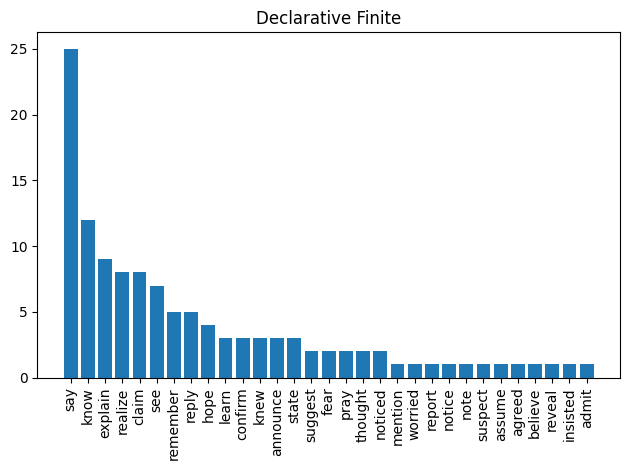

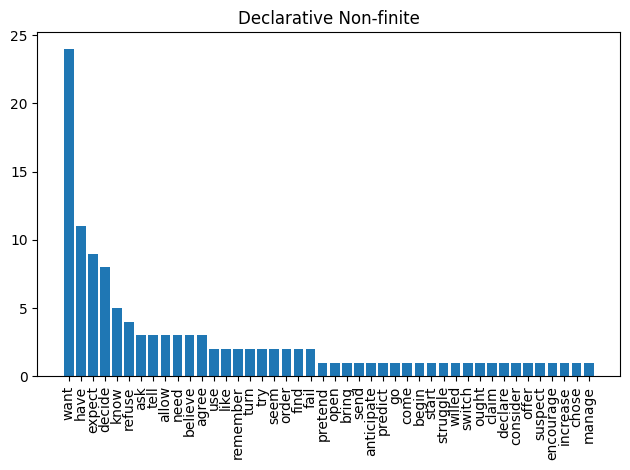

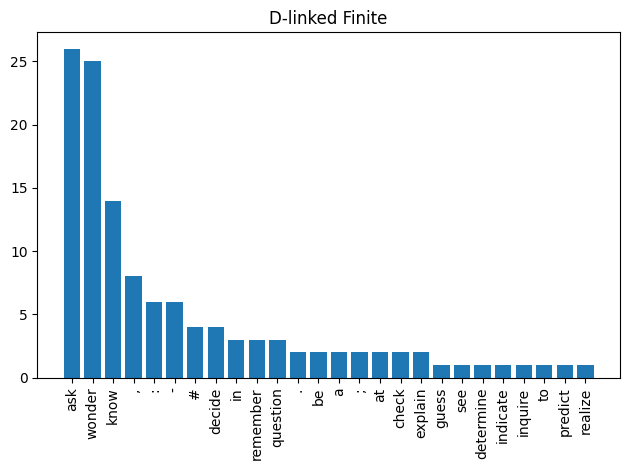

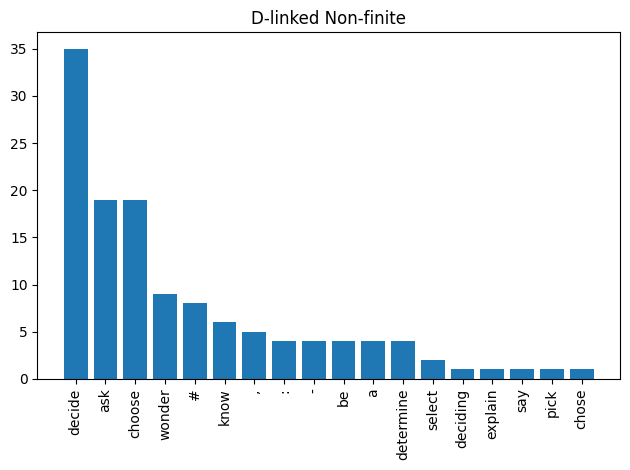

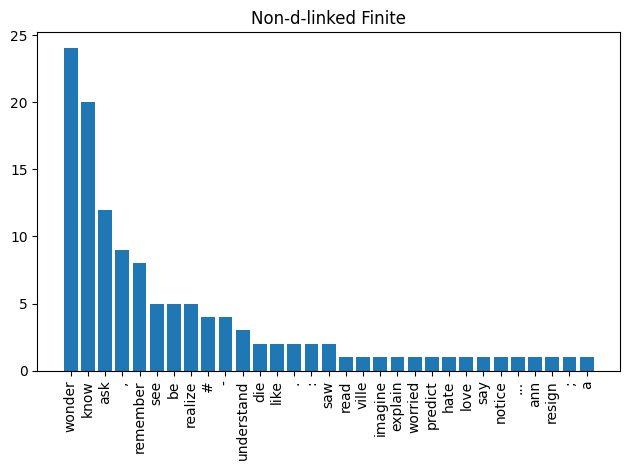

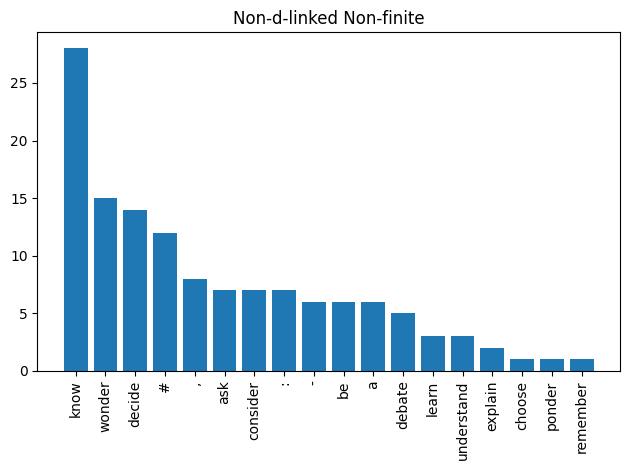

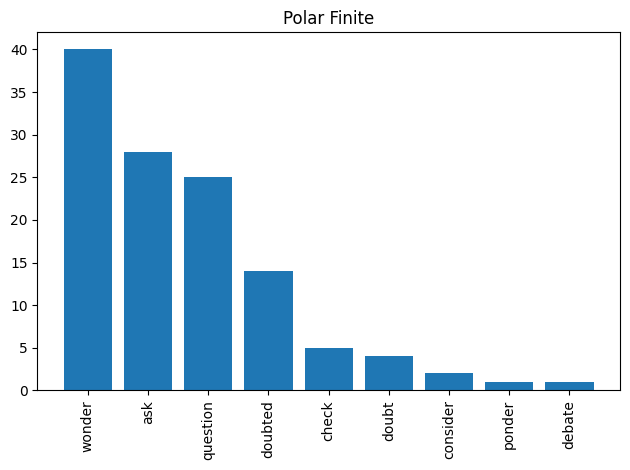

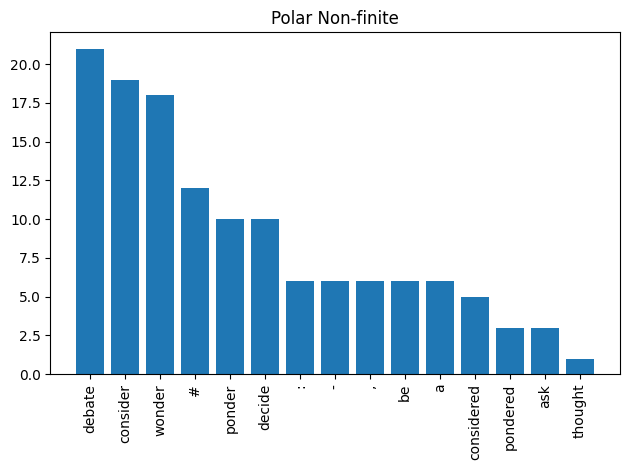

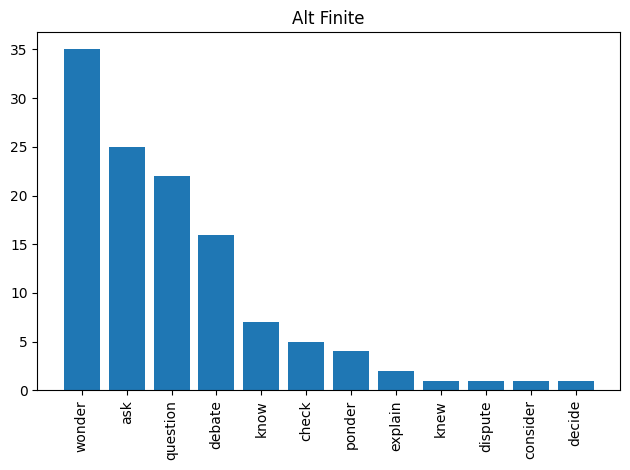

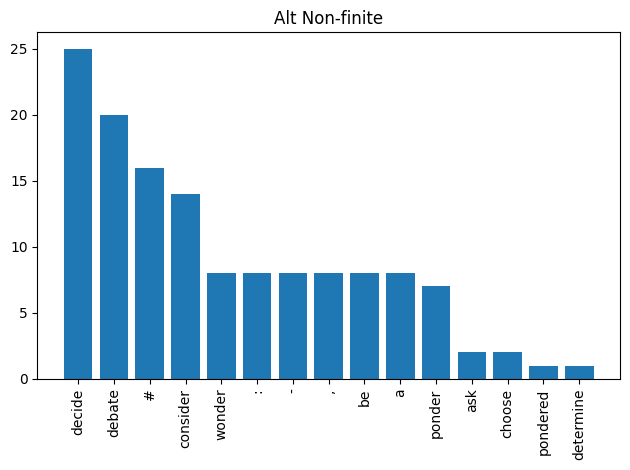

In [12]:

import matplotlib.pyplot as plt


#from nltk.stem import WordNetLemmatizer
#wnl = WordNetLemmatizer()
#wnl.lemmatize('ducks')




def count_elements(word_list):
    words = ' '.join(word_list)
    #print(words)
    token_list = [token.lemma_ for token in nlp(words)]
    #token_list = [wnl.lemmatize(x) for x in word_list]
    #print(token_list)
    
    count_dict = {}
    for x in token_list:
        count_dict[x]= token_list.count(x)

    sorted_count_dict = dict(sorted(count_dict.items(), key=lambda item: item[1], reverse=True))
    #print(sorted_count_dict)
    return sorted_count_dict




for key, listy in pred_dict.items():
    #plt.figure(figsize=(10, 10))
    count_elements(listy)
    list_count = count_elements(listy)
    names = list(list_count.keys())
    values = list(list_count.values())
    plt.bar(range(len(list_count)), values, tick_label=names)
    plt.xticks(rotation=90) 
    plt.title(key)  # Optional: add title
    plt.tight_layout() 
    plt.show()
   # print()

        

# NSP

In [13]:
verbs = ["prefers", "wonders", "wants", "regrets", "believes"]

# here, we would need judgements from MECORE

In [14]:
def create_nsp_pairs(sent_type_dict, verb):
    nlp_pair_dict = {}
    #print(sent_type_dict)
    for clause_type in sent_type_dict:
        nlp_pair_dict[clause_type] = [(f"Mary {verb}", x) for x in sent_type_dict[clause_type]]

    return nlp_pair_dict
    

In [15]:
nsp_pair_clause = create_nsp_pairs(sent_type_dict, "wants")


In [16]:

for key, nsp_pairs, in nsp_pair_clause.items():
    all_is_next = 0
    for sent_a, sent_b in nsp_pairs:
        inputs = tokenizer(sent_a, sent_b, return_tensors="pt", padding=True, truncation=True)

        with torch.no_grad():
            outputs = model(**inputs)
            nsp_logits = outputs.seq_relationship_logits
            probs = torch.softmax(nsp_logits, dim=1)
    
        is_next_prob = probs[0][0].item()
        not_next_prob = probs[0][1].item()

        
        all_is_next += is_next_prob
        
        
        #print(f"A: {sent_a}")
        #print(f"B: {sent_b}")
        #print(f"Is Next: {is_next_prob:.4f}, Not Next: {not_next_prob:.4f}\n")

    print(key)
    print(all_is_next/len(nsp_pairs))

Declarative Finite
0.6009322926014041
Declarative Non-finite
0.877226883060454
D-linked Finite
0.4677984135147805
D-linked Non-finite
0.8218698107715076
Non-d-linked Finite
0.45044871245045215
Non-d-linked Non-finite
0.9431712031364441
Polar Finite
0.2666772411709341
Polar Non-finite
0.9296265753606955
Alt Finite
0.05325490734927977
Alt Non-finite
0.8413203380381068


In [17]:
#GPT NSP


nsp_pairs = [
    ("The sun rises", "in the east."),  # is next
    ("The sun rises", "in the west."),
    ("Apples are red.", "Cars can be expensive."),           # not next
    ("Apples are red.", "The man is on the helicopter."), 
    ("Water appears", "happening"),
    ("Water appears", "boiling"),
    ("Water appears", "to be boiling"),
]


for sent_a, sent_b in nsp_pairs:
    inputs = tokenizer(sent_a, sent_b, return_tensors="pt", padding=True, truncation=True)

    with torch.no_grad():
        outputs = model(**inputs)
        nsp_logits = outputs.seq_relationship_logits
        probs = torch.softmax(nsp_logits, dim=1)

    is_next_prob = probs[0][0].item()
    not_next_prob = probs[0][1].item()
    print(f"A: {sent_a}")
    print(f"B: {sent_b}")
    print(f"Is Next: {is_next_prob:.4f}, Not Next: {not_next_prob:.4f}\n")


A: The sun rises
B: in the east.
Is Next: 1.0000, Not Next: 0.0000

A: The sun rises
B: in the west.
Is Next: 1.0000, Not Next: 0.0000

A: Apples are red.
B: Cars can be expensive.
Is Next: 0.9992, Not Next: 0.0008

A: Apples are red.
B: The man is on the helicopter.
Is Next: 0.9964, Not Next: 0.0036

A: Water appears
B: happening
Is Next: 0.9982, Not Next: 0.0018

A: Water appears
B: boiling
Is Next: 0.9998, Not Next: 0.0002

A: Water appears
B: to be boiling
Is Next: 1.0000, Not Next: 0.0000

